<a href="https://colab.research.google.com/github/Malaiyarasan/emotion-recognition-cnn/blob/main/notebooks/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- CELL 1 ---
# installs
!pip install -q tensorflow==2.19.0 tensorflow-datasets==4.9.2 opencv-python-headless==4.10.0.84 gradio pillow

# imports
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import cv2
from PIL import Image
import matplotlib.pyplot as plt

print("TF", tf.__version__)
print("tfds", tfds.__version__)
print("OpenCV", cv2.__version__)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.9 MB/s eta 0:00:00
TF 2.19.0
tfds 4.9.2
OpenCV 4.10.0


In [5]:
# Cell A1
!pip install -q tensorflow==2.19.0 opencv-python-headless==4.10.0.84 gradio pillow requests
print("installed")


installed


In [6]:
# Cell A2
from pathlib import Path
import requests

MODEL_DIR = Path("/content/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "emotion_pretrained.h5"

if not MODEL_PATH.exists():
    url = "https://raw.githubusercontent.com/SajalSinha/Facial-Emotion-Recognition/main/FER_model.h5"
    print("Downloading pretrained model ...")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    MODEL_PATH.write_bytes(r.content)
    print("Saved to", MODEL_PATH)
else:
    print("Model already present:", MODEL_PATH)


Saved to /content/models/emotion_pretrained.h5


In [7]:
# Cell A3
import numpy as np, cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
from pathlib import Path

model = load_model("/content/models/emotion_pretrained.h5", compile=False)
print("Loaded model. input_shape:", model.input_shape, "output:", model.output_shape)

# standard FER labels (if model uses different order, adjust)
labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

haar = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar)
print("Face cascade ready:", haar)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loaded model. input_shape: (None, 48, 48, 1) output: (None, 7)
Face cascade ready: /usr/local/lib/python3.12/dist-packages/cv2/data/haarcascade_frontalface_default.xml


In [8]:
# Cell A4
import numpy as np
def preprocess_for_model_from_pil(img_pil, target_size=(48,48)):
    img = np.array(img_pil.convert("RGB"))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30,30))
    if len(faces)==0:
        # fallback: center crop
        h,w = gray.shape
        s = min(h,w)
        cx,cy = w//2, h//2
        crop = gray[cy-s//2:cy+s//2, cx-s//2:cx+s//2]
        if crop.size==0:
            crop = cv2.resize(gray, target_size)
        else:
            crop = cv2.resize(crop, target_size)
    else:
        faces = sorted(faces, key=lambda b: b[2]*b[3], reverse=True)
        x,y,w,h = faces[0]
        crop = gray[y:y+h, x:x+w]
        crop = cv2.resize(crop, target_size)
    crop = crop.astype("float32")/255.0
    crop = np.expand_dims(crop, axis=(0,-1))  # (1,H,W,1)
    return crop

def predict_from_pil(img_pil):
    x = preprocess_for_model_from_pil(img_pil)
    preds = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(preds))
    return labels[idx], float(preds[idx]), preds


Saving download (2).jpg to download (2).jpg


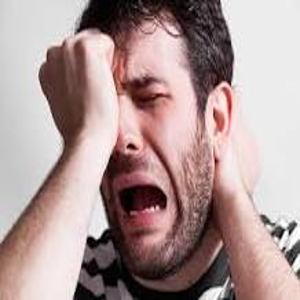

Predicted: angry (35.31%)
 angry   : 35.31%
 disgust :  6.25%
 fear    : 23.89%
 happy   :  2.46%
 neutral :  7.96%
 sad     : 21.88%
 surprise:  2.24%


In [9]:
# Cell A5
from google.colab import files
from PIL import Image, ImageOps
uploaded = files.upload()
for fn in uploaded.keys():
    path = "/content/" + fn
    img = Image.open(path)
    display(img.resize((300,300)))
    label, conf, probs = predict_from_pil(img)
    print("Predicted:", label, f"({conf*100:.2f}%)")
    for i,l in enumerate(labels):
        print(f" {l:8s}: {probs[i]*100:5.2f}%")


In [10]:
# Cell A6
import gradio as gr
def gr_predict(image):
    from PIL import Image
    if image is None: return {l:0.0 for l in labels}
    pil = Image.fromarray(image) if isinstance(image, (np.ndarray,)) else image
    _,_,p = predict_from_pil(pil)
    return {labels[i]: float(p[i]) for i in range(len(labels))}

demo = gr.Interface(fn=gr_predict,
                    inputs=gr.Image(type="numpy"),
                    outputs=gr.Label(num_top_classes=3),
                    title="Emotion Recognition (pretrained)",
                    description="Upload or use webcam (frontal face).")
app = demo.launch(share=True)
print("Gradio link:", getattr(app,"share_url","see output above"))


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a5abcf716057fcd866.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Gradio link: see output above


In [11]:
from google.colab import files
from pathlib import Path

p = Path("models/emotion_pretrained.h5")  # or models/emotion_model.h5 / models/simple_fer_cnn.h5 — adjust if different
print("Exists:", p.exists(), "Path:", p)
if not p.exists():
    raise FileNotFoundError("Model not found at " + str(p))
files.download(str(p))


Exists: True Path: models/emotion_pretrained.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>